In [17]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Load and reduce MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5  # Normalize
x_train = x_train[:2000]  # Use only 2k samples
x_train = x_train.reshape((-1, 28, 28, 1)).astype('float32')

BUFFER_SIZE = 2000
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [19]:
# Simple Generator
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*64, use_bias=False, input_shape=(100,)),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 64)),
        layers.Conv2DTranspose(32, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(16, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [20]:
# Simple Discriminator
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [21]:
# Loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator = make_generator_model()
discriminator = make_discriminator_model()
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real = cross_entropy(tf.ones_like(real_output), real_output)
    fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real + fake

In [22]:
# Training setup
EPOCHS = 1
noise_dim = 100
num_examples = 16
seed = tf.random.normal([num_examples, noise_dim])

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_disc, discriminator.trainable_variables))

In [24]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} running...")
        for image_batch in dataset:
            train_step(image_batch)
        print("Sample output:")
        generate_images(generator, seed)

In [25]:
# Display generated digits
def generate_images(model, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2.0, cmap='gray')
        plt.axis('off')
    plt.show()

Epoch 1 running...
Sample output:


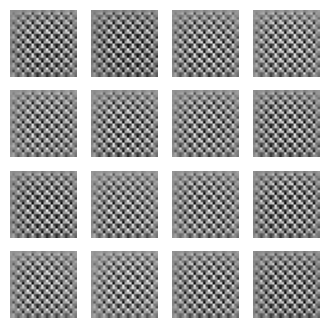

In [26]:
# Train the model
train(train_dataset, EPOCHS)